In [1]:
import sys
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

%load_ext autoreload
%autoreload 2
%matplotlib widget

# Load Data from Folders


In [2]:
from io import StringIO


data: dict[str, dict[str, dict[str, pd.DataFrame]]] = {}

directories = []
for root, dirs, files in os.walk("../../../../data/benchmark-cluster/SpinodalDecompositionMPI/"):
    for name in dirs:
        directories.append(os.path.join(root, name))

count = 0
for directory in directories:
    files = os.listdir(directory)

    for file in files:
        # skip folders
        if ".csv" not in file:
            continue

        file_type = file.split("_")[1]

        tuning_algorithm = directory.split("/")[-1]
        rank = directory.split("/")[-2]
        thread = directory.split("/")[-3]
        scenario = directory.split("/")[-4]

        with open(os.path.join(directory, file)) as f:
            content = f.read()
            df_tuners = pd.read_csv(StringIO(content))

        if not scenario in data:
            data[scenario] = {}

        if not thread in data[scenario]:
            data[scenario][thread] = {}

        if not rank in data[scenario][thread]:
            data[scenario][thread][rank] = {}

        if not tuning_algorithm in data[scenario][thread][rank]:
            data[scenario][thread][rank][tuning_algorithm] = {}

        print(f"Adding {file} to {scenario} {
              thread} {rank} {tuning_algorithm}")

        data[scenario][thread][rank][tuning_algorithm][file_type] = df_tuners
        count += 1

print(f"Added {count} files")

Adding AutoPas_tuningData_Rank2_2024-07-07_06-05-04.csv to SpinodalDecompositionMPI 14 2 Bayesian-Cluster
Adding AutoPas_tuningResults_Rank2_2024-07-07_06-05-04.csv to SpinodalDecompositionMPI 14 2 Bayesian-Cluster
Adding AutoPas_iterationPerformance_Rank2_2024-07-07_06-05-04.csv to SpinodalDecompositionMPI 14 2 Bayesian-Cluster
Adding AutoPas_iterationPerformance_Rank2_2024-07-03_20-48-26.csv to SpinodalDecompositionMPI 14 2 FuzzyTuning [Suitability]
Adding AutoPas_tuningResults_Rank2_2024-07-03_20-48-25.csv to SpinodalDecompositionMPI 14 2 FuzzyTuning [Suitability]
Adding AutoPas_tuningData_Rank2_2024-07-03_20-48-26.csv to SpinodalDecompositionMPI 14 2 FuzzyTuning [Suitability]
Adding AutoPas_iterationPerformance_Rank2_2024-07-05_23-41-15.csv to SpinodalDecompositionMPI 14 2 Bayesian
Adding AutoPas_tuningResults_Rank2_2024-07-05_23-41-15.csv to SpinodalDecompositionMPI 14 2 Bayesian
Adding AutoPas_tuningData_Rank2_2024-07-05_23-41-15.csv to SpinodalDecompositionMPI 14 2 Bayesian
Addi

# Make Line Plot of Smoothed Value over Iterations


37.518647000075
35.9576730476
37.002566979275
31.809174938500004
35.070230859225
25.391135220724998
34.275306631999996
34.16963896875
33.47581490195
34.862138330625
29.251036885174997
22.734331595275
35.300162672175
35.037783662225
34.8893913567
31.514932239975
32.94786373515
25.89249974385
38.075837892075
37.529495433925
35.957998437175
34.014102360725
32.3866012273
26.491502135775


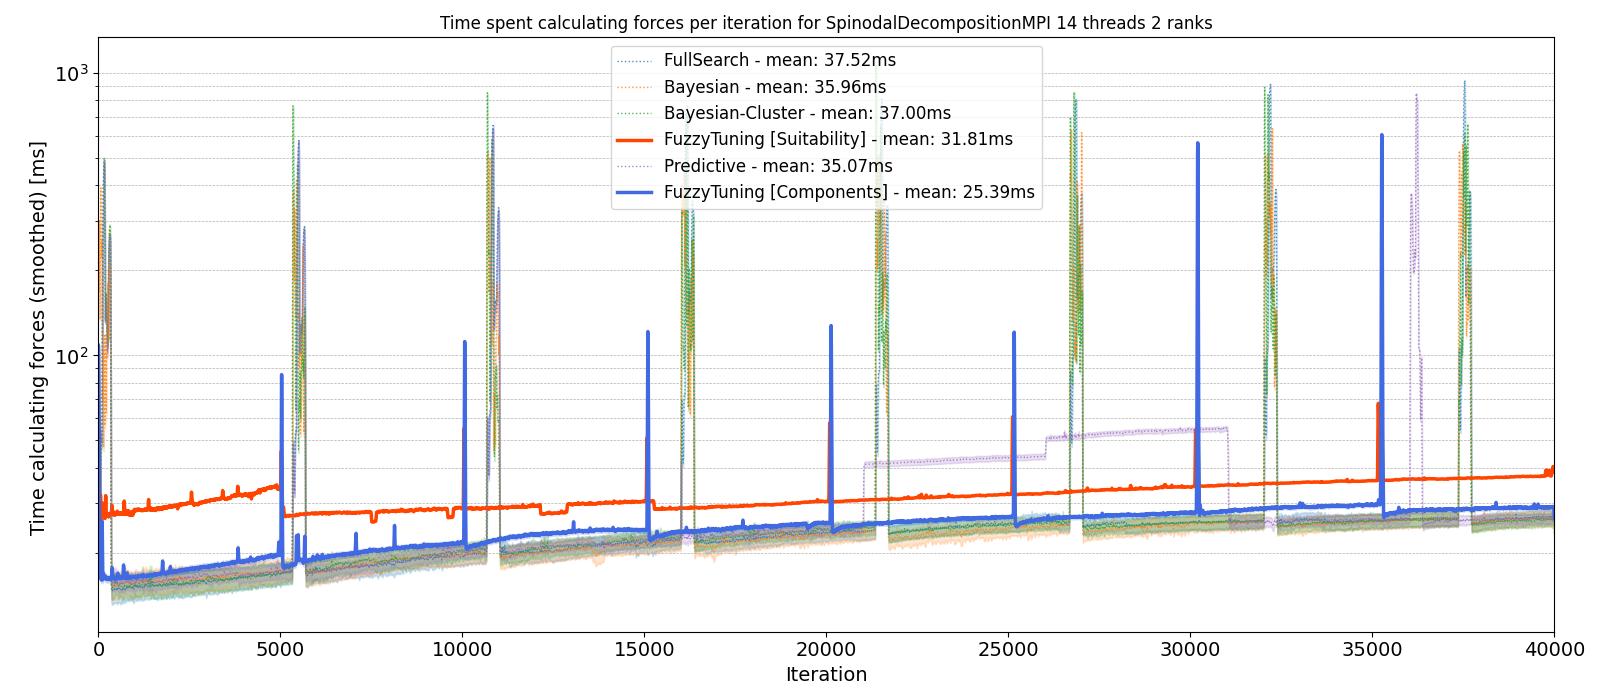

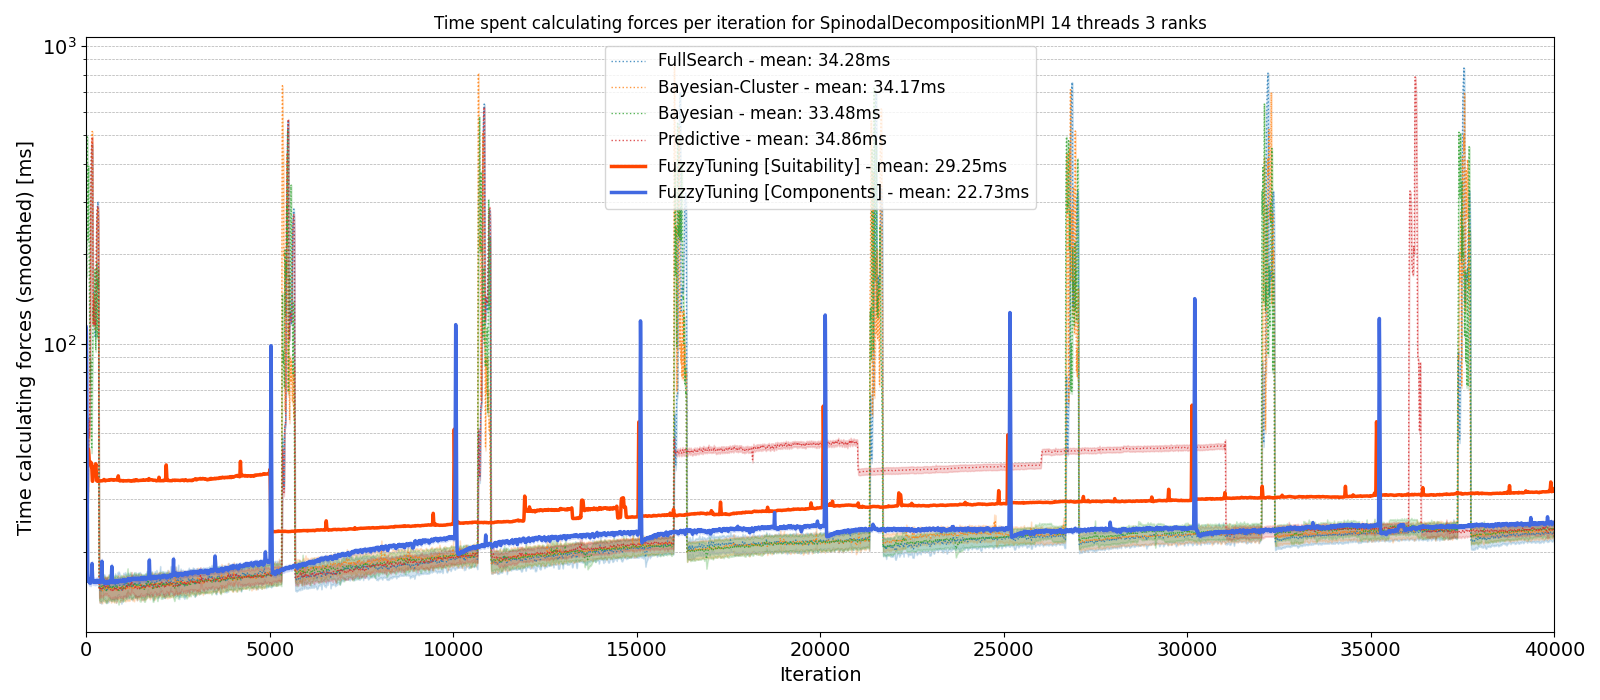

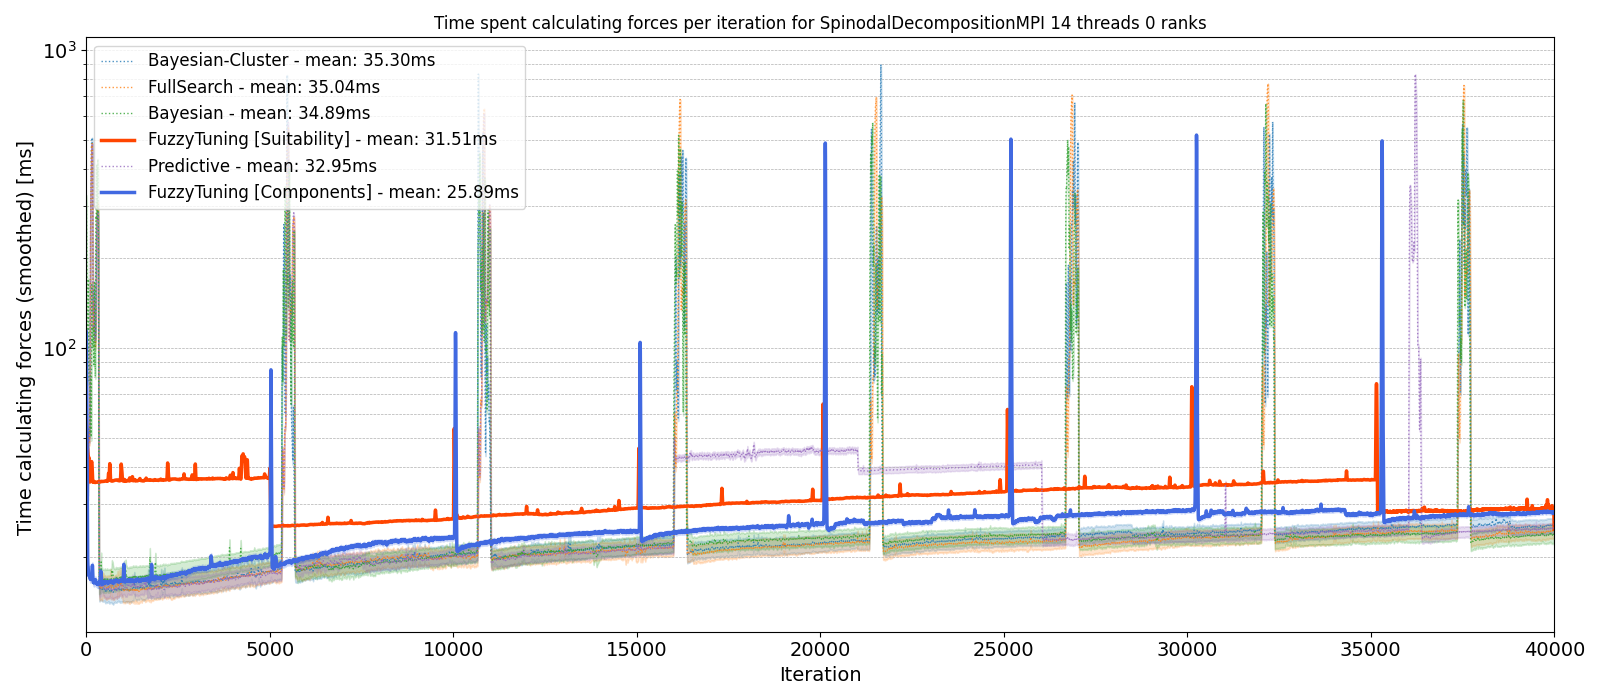

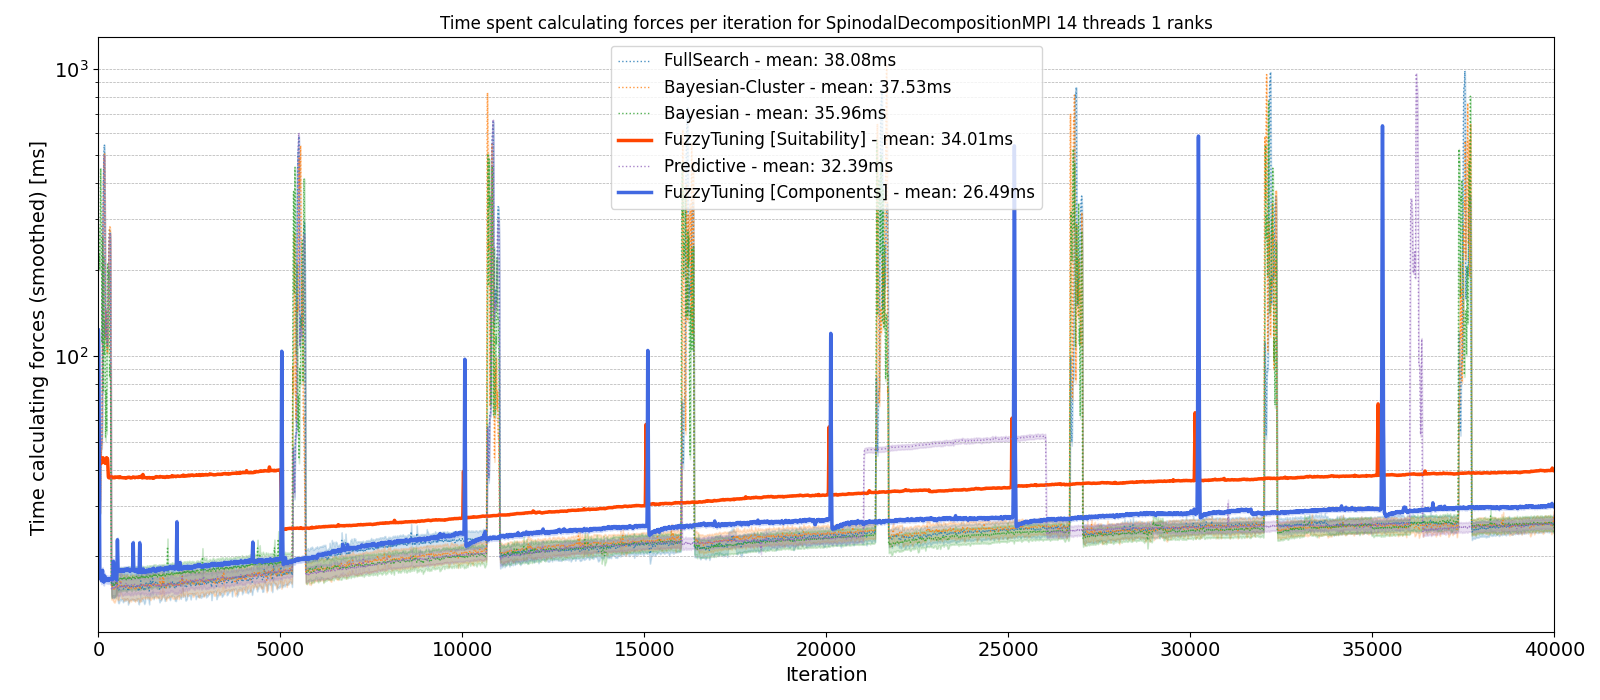

In [3]:
from scipy.signal import lfilter
from tsmoothie.smoother import *

for scenario, s_data in data.items():

    for threads, t_data in s_data.items():

        for rank, r_data in t_data.items():

            fig, ax = plt.subplots(1, 1, figsize=(16, 7))

            min_y=np.inf
            max_y=-np.inf
            # sort by mean time spent calculating forces
            for tuning_algorithm, logs in sorted(r_data.items(), key=lambda x: x[1]["iterationPerformance"]["iteratePairwiseTotal[ns]"].mean(), reverse=True):

                iteration_data = logs["iterationPerformance"]

                time_s = iteration_data["iteratePairwiseTotal[ns]"] / 1e9

                first_k = 40000

                x = iteration_data["Iteration"][:first_k]
                y = time_s[:first_k] * 1000

                min_y = min(min_y, y.min())
                max_y = max(max_y, y.max())
                mean = y.mean()

                print(mean)

                if np.logical_or(np.isnan(y), np.isinf(y)).any():
                    raise ValueError(f"Found NaN or Inf in {
                        tuning_algorithm + threads + scenario}")

                smoother = ConvolutionSmoother(
                    window_len=40, window_type='blackman')
                smoother.smooth(y)
                low, up = smoother.get_intervals(
                    'sigma_interval', n_sigma=0.02)

                linewidth = 2.5 if "Fuzzy" in tuning_algorithm else 1
                opacity = 1 if "Fuzzy" in tuning_algorithm else 0.8
                linestyle = "-" if "Fuzzy" in tuning_algorithm else ":"

                color = ax._get_lines.get_next_color()
                if "Suitability" in tuning_algorithm:
                    color = "orangered"
                elif "Components" in tuning_algorithm:
                    color = "royalblue"

                ax.plot(x, smoother.smooth_data[0], label=f"{
                        tuning_algorithm} - mean: {mean:.2f}ms", linewidth=linewidth, alpha=opacity, linestyle=linestyle, color=color)

                ax.fill_between(x, low[0], up[0], alpha=0.2, color=color)

            ax.legend(prop={'size': 12})
            ax.set_xlabel("Iteration")
            ax.set_ylabel(
                "Time calculating forces (smoothed) [ms] ")

            ax.set_xlim(0, first_k)
            # set y axis to mikro seconds

            ax.set_title(f"Time spent calculating forces per iteration for {
                scenario} {threads} threads {rank} ranks")
            # ax.set_xlim(0, df["Iteration"].max())
            # log

            # make y axis bigger
            ax.yaxis.set_tick_params(labelsize=14)
            ax.xaxis.set_tick_params(labelsize=14)
            # make axis title bigger
            ax.yaxis.label.set_size(14)
            ax.xaxis.label.set_size(14)

            fig.tight_layout()

            #grid and subgrid
            ax.grid("on", which="both", ls="--", linewidth=0.5,axis="y")

            # logarithmic scale
            ax.set_yscale('log')

            fig.savefig(
                f"SpinodalDecompositionMPI_timings_{scenario}_{threads}_{rank}.png", dpi=300)

# Make bar plots about total time

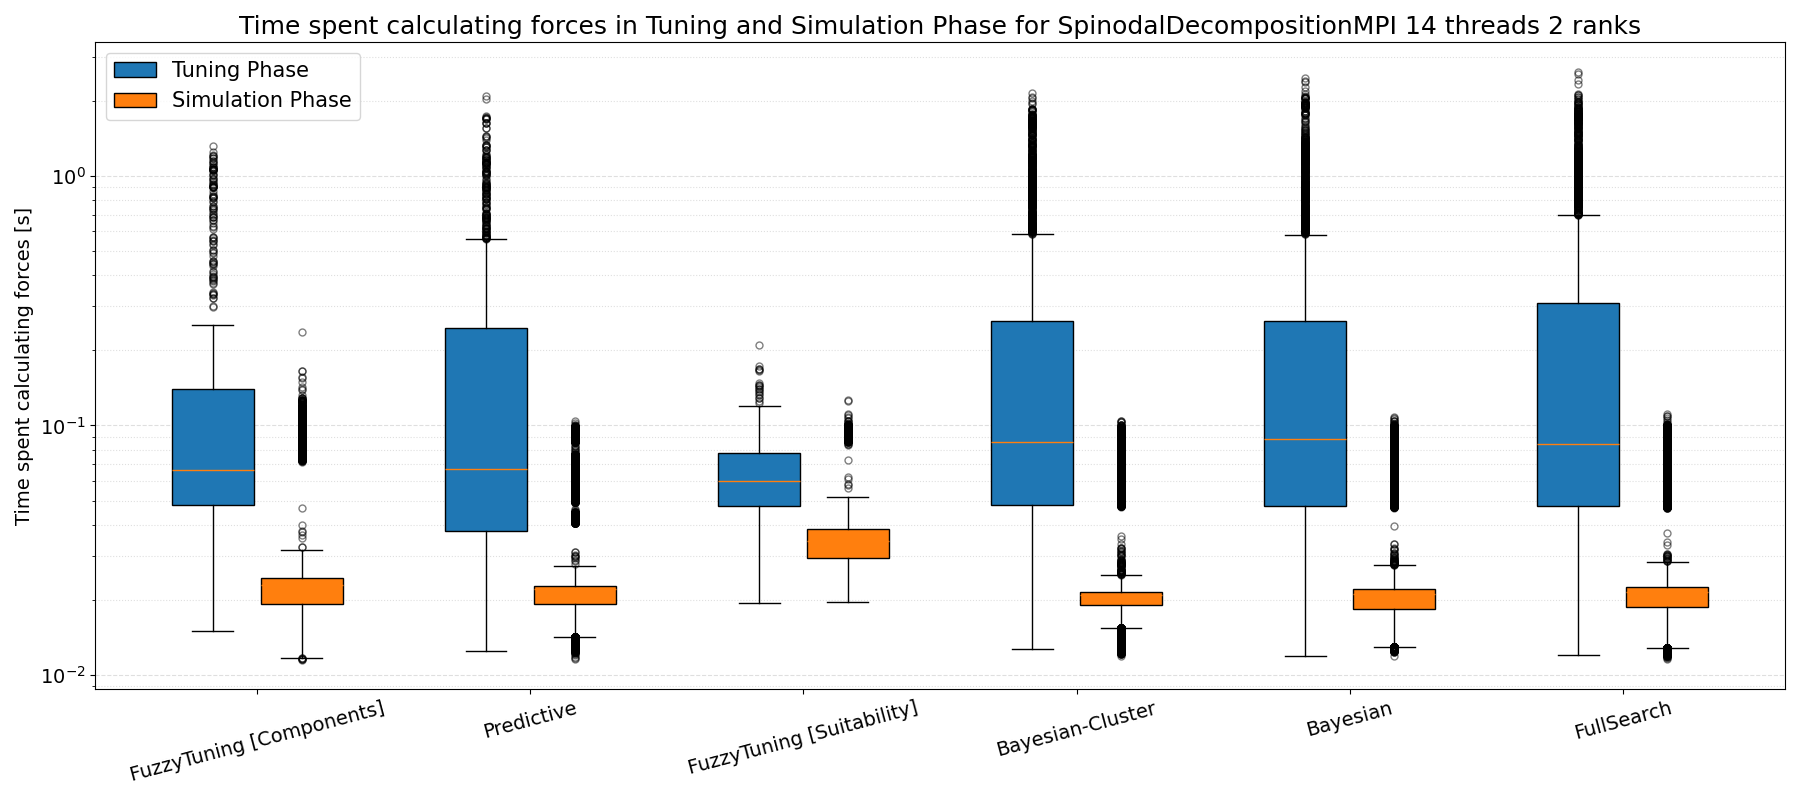

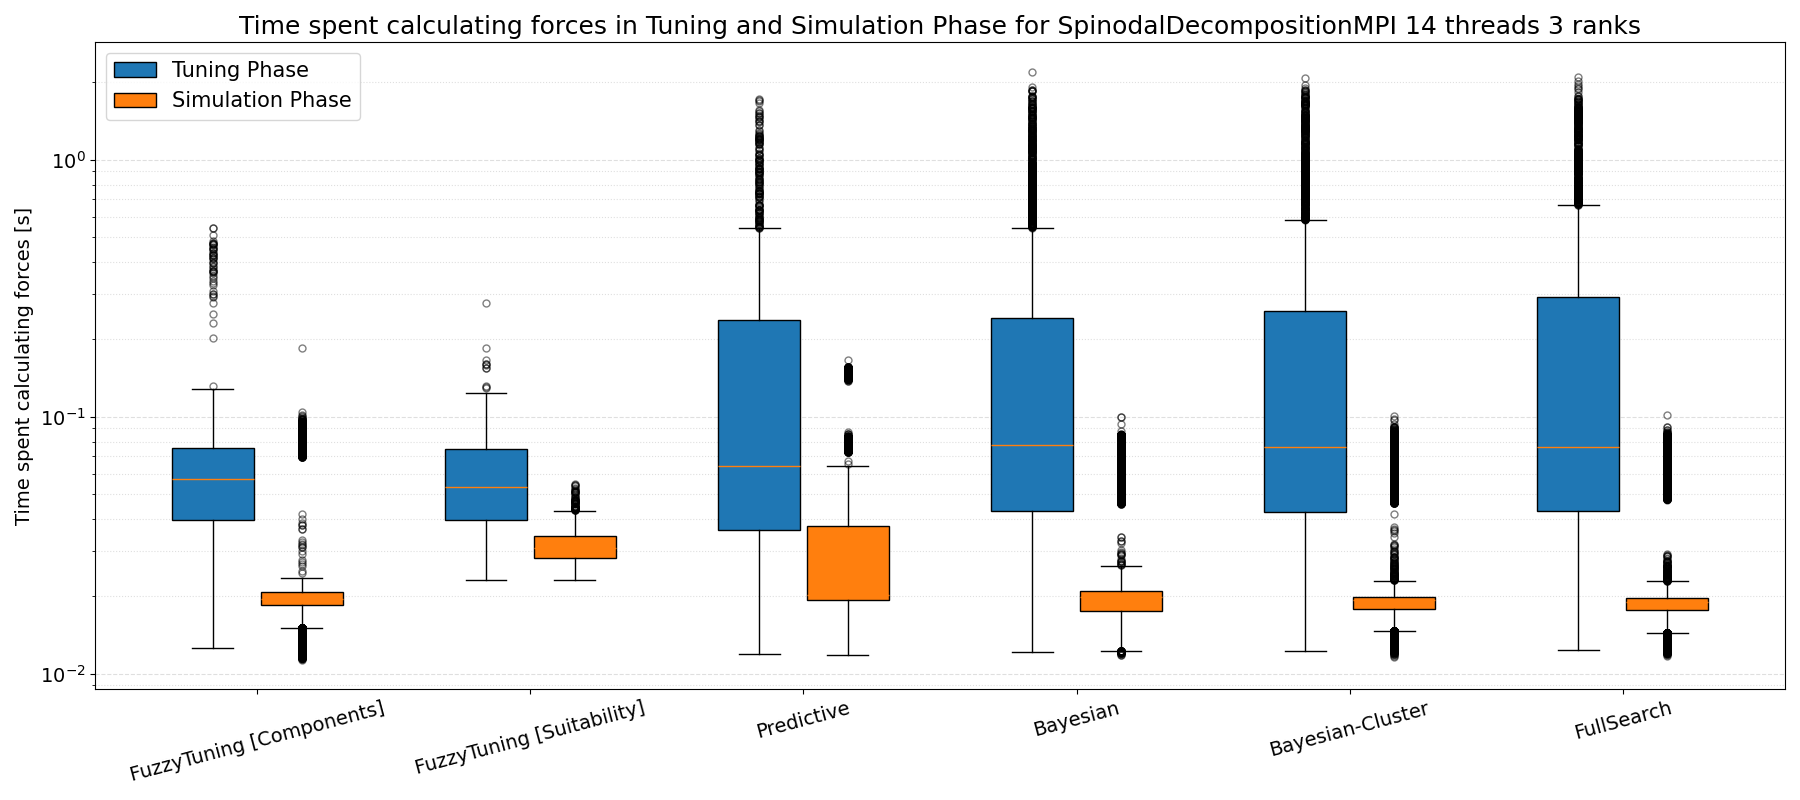

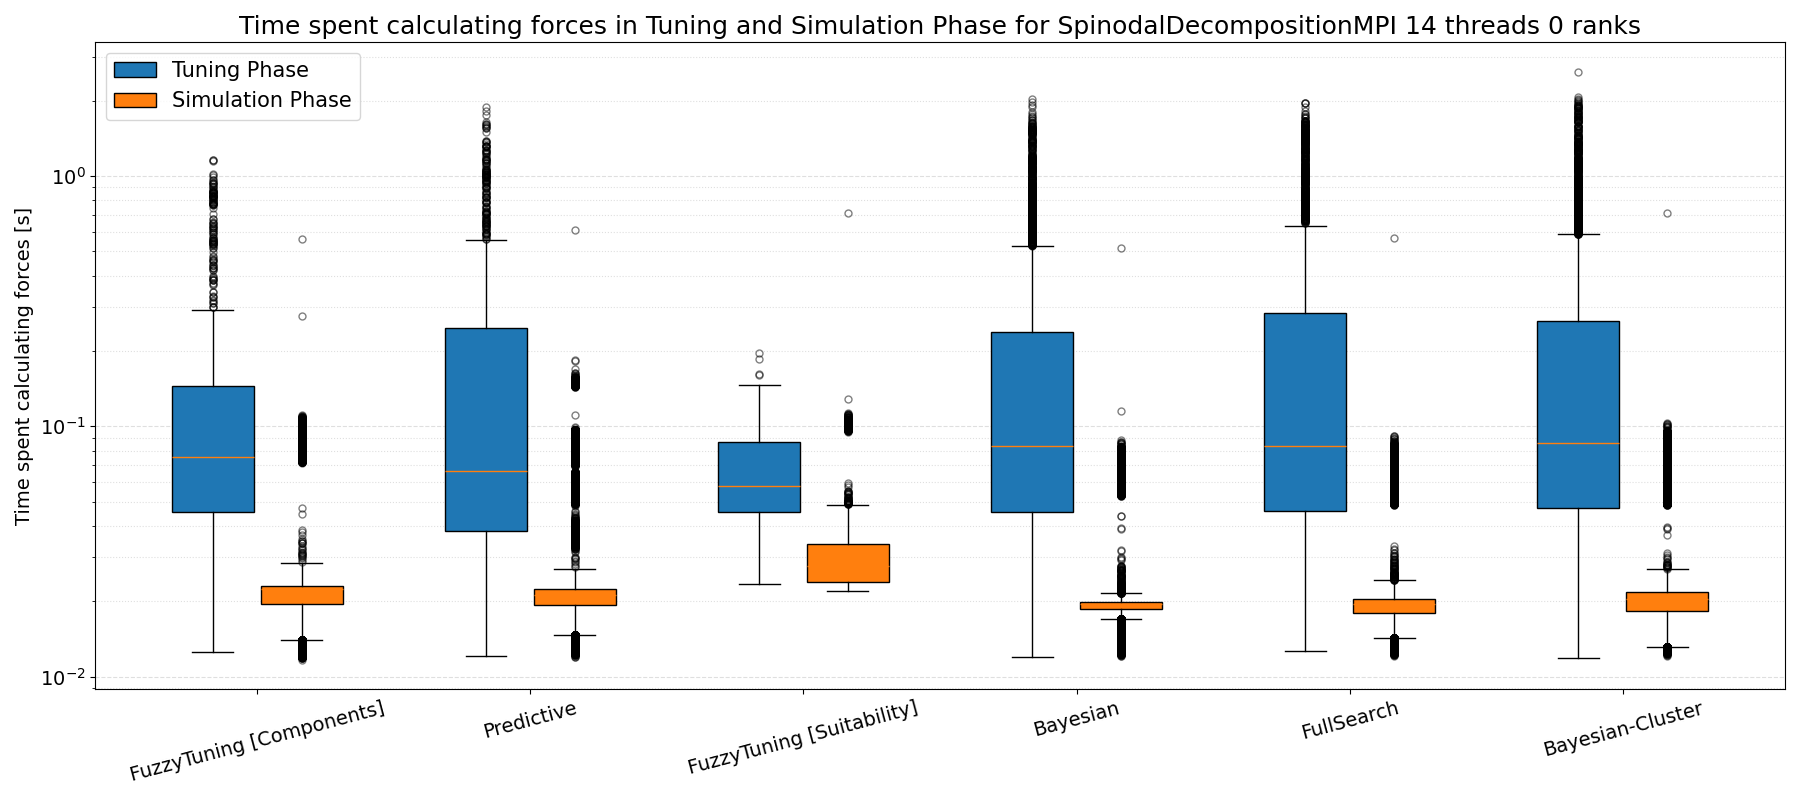

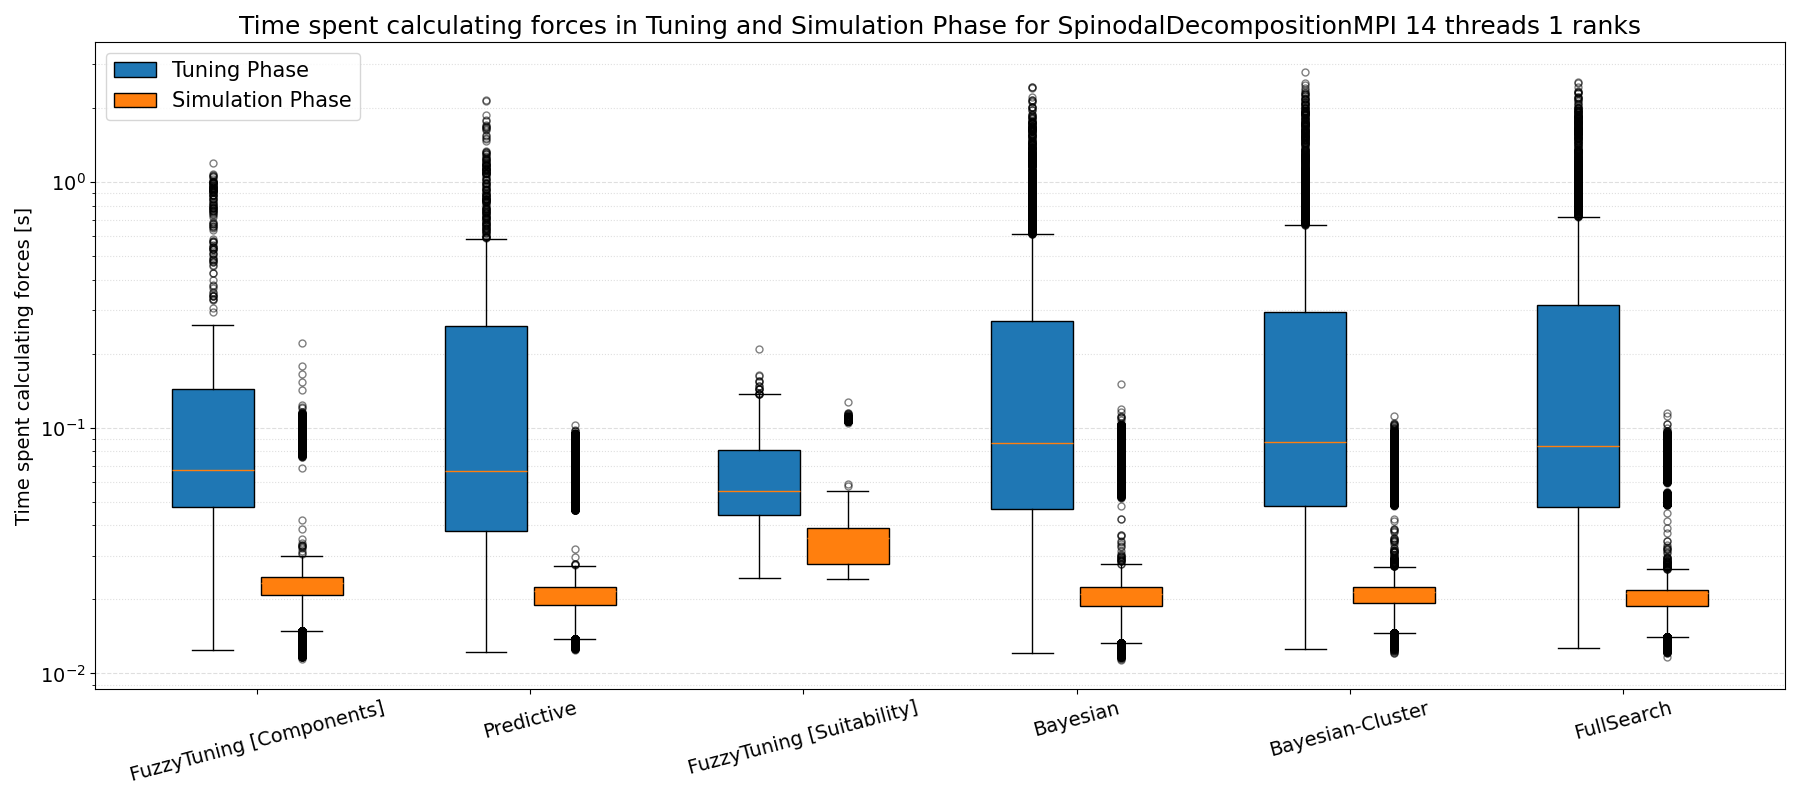

In [4]:
for scenario, s_data in data.items():
    for threads, t_data in sorted(s_data.items(), key=lambda x: x[0]):

        for rank, r_data in t_data.items():

            timings = {}
            algorithms = []

            # Collect data
            for tuning_algorithm, logs in sorted(r_data.items(), key=lambda x: x[1]["iterationPerformance"]["iteratePairwiseTotal[ns]"].sum(), reverse=False):
                algorithms.append(tuning_algorithm)
                iteration_data = logs["iterationPerformance"]
                tuning_iterations = iteration_data[iteration_data["inTuningPhase"] == True]
                simulation_iterations = iteration_data[iteration_data["inTuningPhase"] == False]

                timings[tuning_algorithm] = {
                    "Tuning Phases": tuning_iterations["iteratePairwiseTotal[ns]"] / 1e9,
                    "Simulation Phases": simulation_iterations["iteratePairwiseTotal[ns]"] / 1e9
                }
            # Create plot
            fig, ax = plt.subplots(figsize=(18, 8))

            # Set positions for boxplots
            # Increased spacing between algorithm groups
            positions = range(0, len(algorithms) * 4, 4)
            width = 1.2  # Increased width of boxes

            # Function to add jittered points
            def add_jittered_points(data, pos, color, alpha=0.2):
                y = data
                x = np.random.normal(pos, 0.1, size=len(y))
                ax.scatter(x, y, alpha=alpha, s=10, color=color, zorder=3)
            # Create boxplots with jittered outliers
            bp_tuning = ax.boxplot([timings[alg]["Tuning Phases"] for alg in algorithms],
                                   positions=[p - width/2 -
                                              0.05 for p in positions],
                                   widths=width, patch_artist=True, flierprops=dict(marker='o', markersize=5, alpha=0.5))

            bp_simulation = ax.boxplot([timings[alg]["Simulation Phases"] for alg in algorithms],
                                       positions=[p + width/2 +
                                                  0.05 for p in positions],
                                       widths=width, patch_artist=True, flierprops=dict(marker='o', markersize=5, alpha=0.5))

            # Add scatter plots
            # for i, alg in enumerate(algorithms):
            #     add_jittered_points(
            #         timings[alg]["Tuning Phases"], positions[i] - width/2, '#3498db')
            #     add_jittered_points(
            #         timings[alg]["Simulation Phases"], positions[i] + width/2, '#e67e22')

            # Increase font sizes
            plt.title(
                f'Time spent calculating forces in Tuning and Simulation Phase for {scenario} {threads} threads {rank} ranks', fontsize=18)
            ax.set_ylabel('Time spent calculating forces [s]', fontsize=16)

            # Rotate x-axis labels
            plt.xticks(rotation=15, fontsize=14)
            plt.yticks(fontsize=14)

            # Use more distinct colors
            for box in bp_tuning['boxes']:
                box.set(facecolor='#1f77b4')
            for box in bp_simulation['boxes']:
                box.set(facecolor='#ff7f0e')  # Orange

            ax.set_xticks(positions)
            ax.set_xticklabels(algorithms, rotation=15)

            # minor grid lines on y
            ax.yaxis.grid(True, linestyle=':', which='minor',
                          color='grey', alpha=.25)

            # Add legend
            ax.legend([bp_tuning["boxes"][0], bp_simulation["boxes"][0]],
                      ["Tuning Phase", "Simulation Phase"], fontsize=15)

            # Logarithmic y-axis
            ax.set_yscale('log')

            # more grid lines
            ax.yaxis.grid(True, linestyle='--', which='major',
                          color='grey', alpha=.25)

            ax.yaxis.set_tick_params(labelsize=14)
            ax.xaxis.set_tick_params(labelsize=14)
            # make axis title bigger
            ax.yaxis.label.set_size(14)

            fig.tight_layout()

            fig.savefig(f"SpinodalDecompositionMPI_timings_boxplot_{
                        scenario}_{threads}_{rank}.png", dpi=300)

            plt.show()

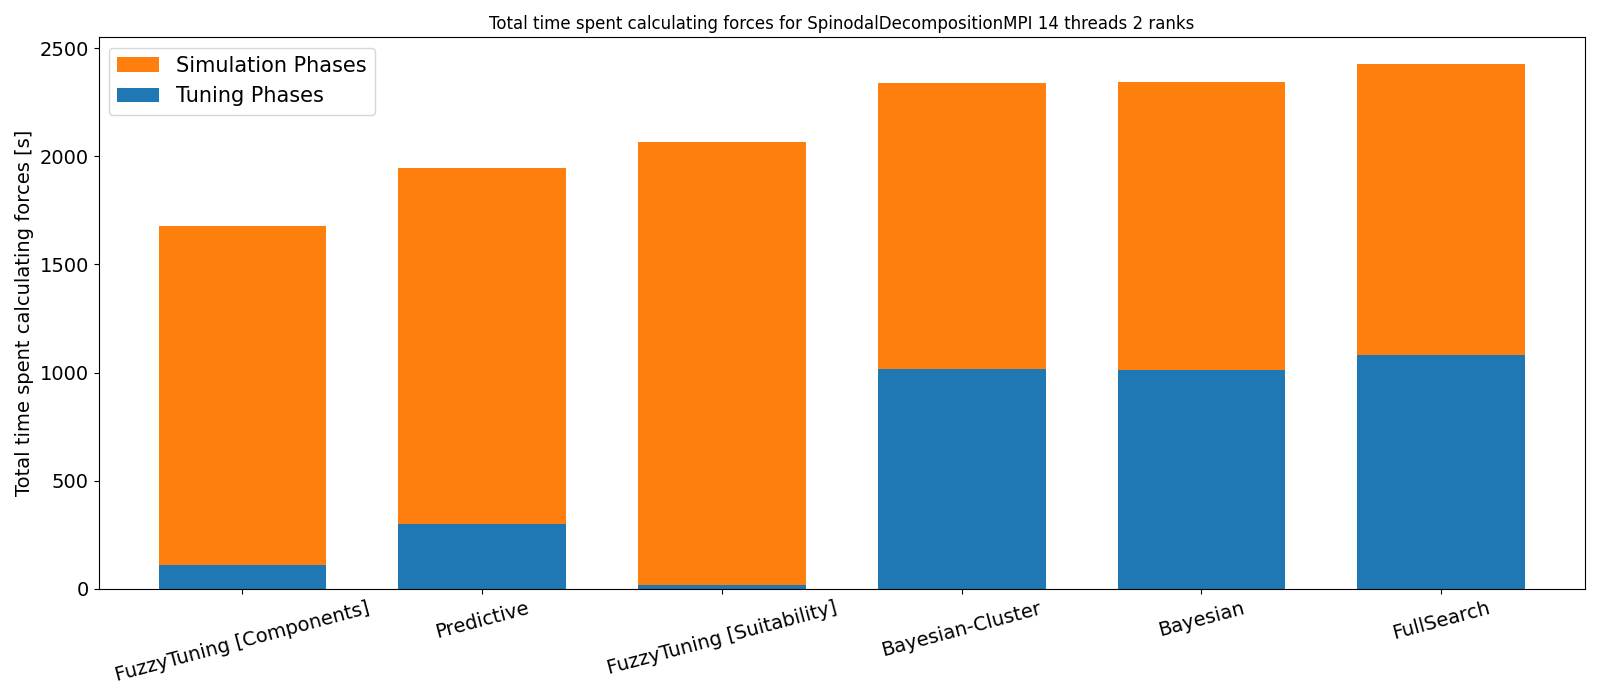

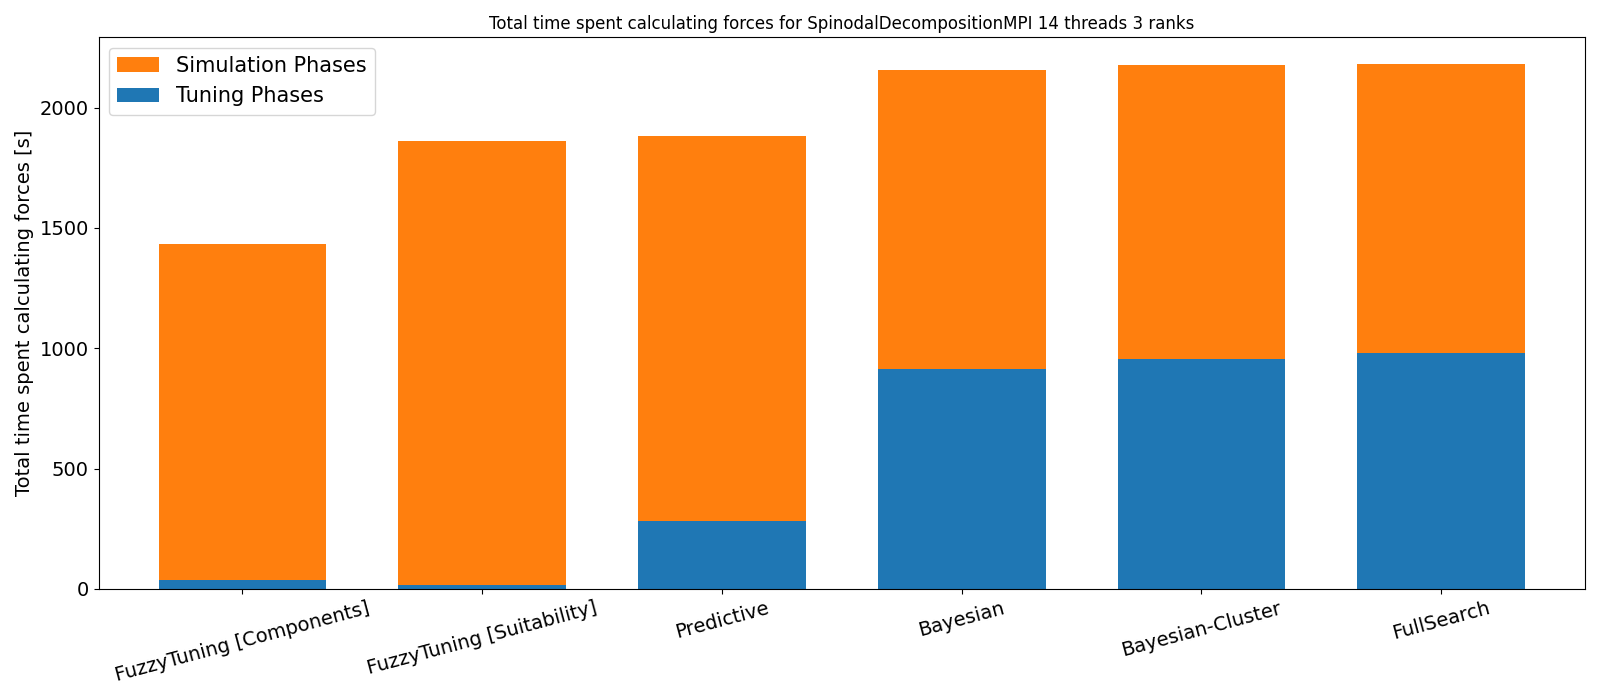

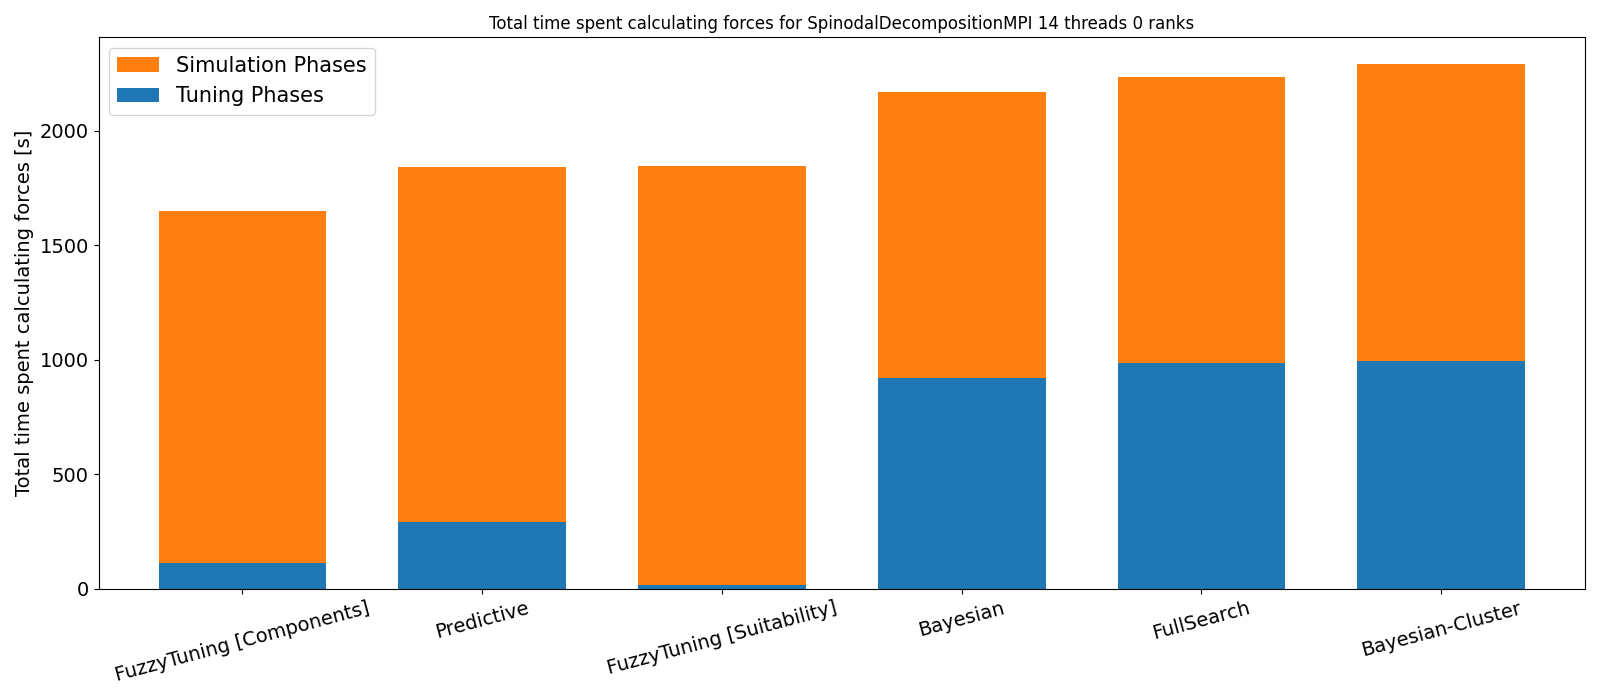

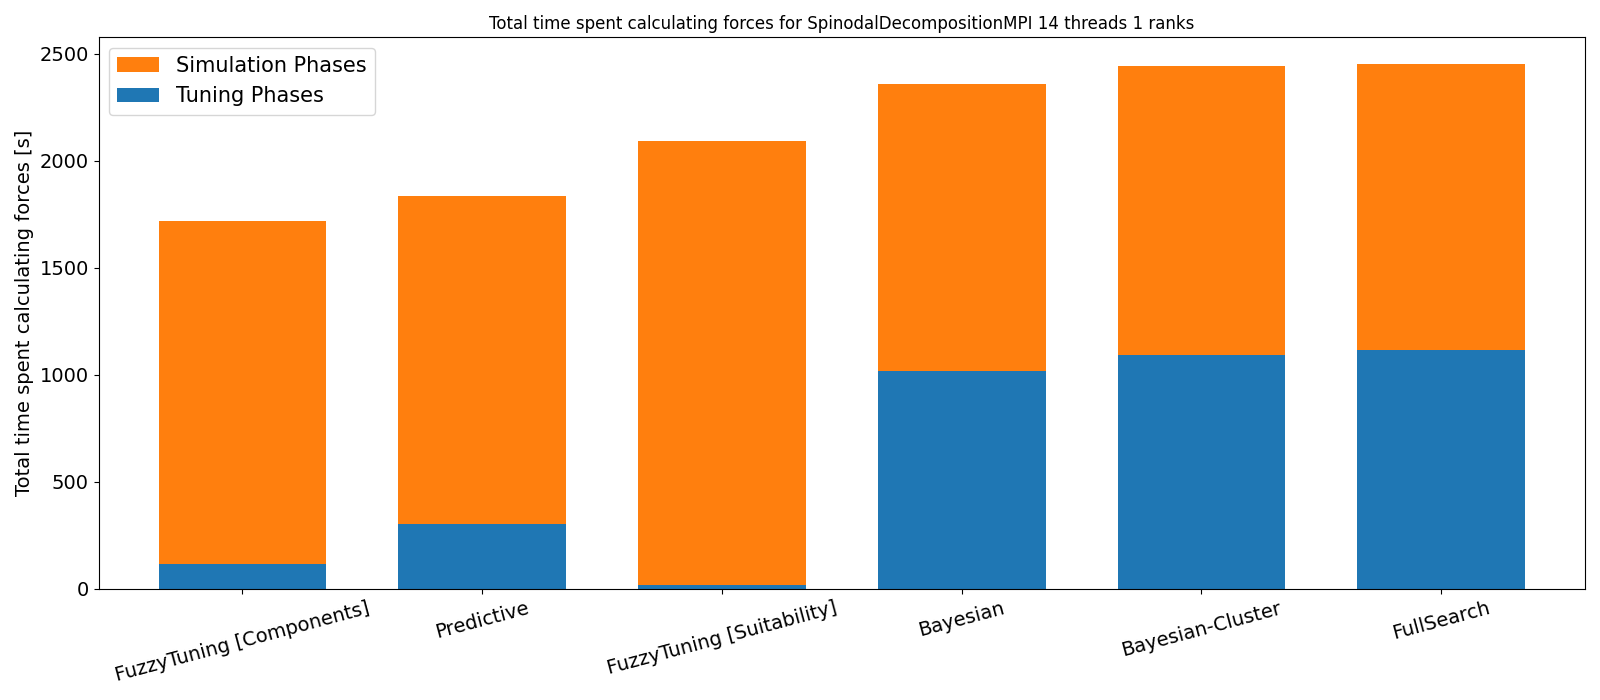

In [6]:
for scenario, s_data in data.items():
    for threads, t_data in sorted(s_data.items(), key=lambda x: x[0]):

        for rank, r_data in t_data.items():

            timings = {}
            algorithms = []

            # Collect data
            for tuning_algorithm, logs in sorted(r_data.items(), key=lambda x: x[1]["iterationPerformance"]["iteratePairwiseTotal[ns]"].sum(), reverse=False):
                algorithms.append(tuning_algorithm)
                iteration_data = logs["iterationPerformance"]
                tuning_iterations = iteration_data[iteration_data["inTuningPhase"] == True]
                simulation_iterations = iteration_data[iteration_data["inTuningPhase"] == False]

                timings[tuning_algorithm] = {
                    "Tuning Phases": tuning_iterations["iteratePairwiseTotal[ns]"].sum() / 1e9,
                    "Simulation Phases": simulation_iterations["iteratePairwiseTotal[ns]"].sum() / 1e9
                }


            # df with tuning algorithm as row
            df = pd.DataFrame(timings).T

            fig, ax = plt.subplots(1, 1, figsize=(16, 7))

            df.plot(kind='bar', stacked=True, ax=ax, width=0.7)

            # tilt x labels
            plt.xticks(rotation=15, fontsize=16)

            ax.set_ylabel(
                "Total time spent calculating forces [s]", fontsize=16)

            ax.set_title(f"Total time spent calculating forces for {
                scenario} {threads} threads {rank} ranks")

            handles, lables = ax.get_legend_handles_labels()
            ax.legend(handles[::-1], lables[::-1], prop={'size': 15})

            # make y axis bigger
            ax.yaxis.set_tick_params(labelsize=14)
            ax.xaxis.set_tick_params(labelsize=14)
            # make axis title bigger
            ax.yaxis.label.set_size(14)

            fig.tight_layout()

            # logarithmic scale

            fig.savefig(f"SpinodalDecompositionMPI_timings_total_{
                        scenario}_{threads}_{rank}.png", dpi=300)